# This is Version 1 of our visualization tool
I use the following code to display feature lines (detected by CrestCODE based on curvature)

In [571]:
import os
import numpy as np
import open3d as o3d
import igl
import meshplot as mp
from matplotlib import pyplot as plt
from matplotlib import cm
import math
import json

In [317]:
# extensions
PLY = ".ply"
TXT = ".txt"
# utility
NEIGHBOR = 6
MESHNAME = "tbk_crop_230328_depth=12_correctNormals_radarArchitectureONLY_smaller"
MESHFILE = "../Open3D_Test/" + MESHNAME + PLY
PSEUDO_PLY2 = "ply2" + TXT
NEWLINE = '\n'
MAX_neighbor = 10
CRESTLINE = 1 # 0 means NO Crest line, 1 means YES Crest line
# renaming CrestCode output!
RIDGES = "Ridge_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
RAVINES = "Ravine_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
OUTPUT_rename = "Output_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT
PLY2_rename = "PLY2_" + "k=" + str(NEIGHBOR) + "_" + MESHNAME + TXT

In [724]:
"""Functions: for raw .ply input!"""
# input: mesh file (path)
# output1: vertices (N, 3) array; x y z coordinates
# output2: faces (F, 3) array, format: [a id, b id, c id]
def get_mesh(path):
    mesh = o3d.io.read_triangle_mesh(path)
    print(mesh)
    verts = np.asarray(mesh.vertices)
    faces = np.asarray(mesh.triangles)
    return verts, faces
# input: output file name, neighbor (k), crestline (1 = yes, 0 = no), vertices (array), faces (array)
# does: txt file <- for CrestCODE
def to_pseudo_PLY2(name, neighbor, crestline, verts, faces):
    NEWLINE = '\n'
    verts_count = len(verts)
    faces_count = len(faces)
    with open(name, 'w') as f:
        f.write(str(verts_count) + NEWLINE)
        f.write(str(faces_count) + NEWLINE)
        f.write(str(neighbor) + NEWLINE)
        f.write(str(crestline) + NEWLINE)
        for i in range(verts_count): # all vertices x y z coordinates
            f.write(" ".join(map(str, verts[i])) + NEWLINE)
        for j in range(faces_count): # all faces a b c vertices ids
            f.write(" ".join(map(str, faces[j])) + NEWLINE)
    print(f"Success: {PSEUDO_PLY2}")

In [316]:
mesh_verts, mesh_faces = get_mesh(MESHFILE)
to_pseudo_PLY2(PSEUDO_PLY2, NEIGHBOR, CRESTLINE, mesh_verts, mesh_faces)

TriangleMesh with 3035835 points and 6064854 triangles.
Success: ply2.txt


# BOOM! You ran CrestCODE and got your .txt outputs!
<br>You ran command in the CrestCODE folder (through Terminal) and got .txt files for: output, ravines, ridges
>the input: ./setCurvature ply2.txt output.txt
><br>Note that 'ply2.txt' corresponds to (the value of) PSEUDO_PLY2

<br>The .txt show up in the CrestCODE folder
<br>You moved those files Back to Open3D_Test!

In [318]:
#cleaning up!
os.rename("ridges.txt", RIDGES)
os.rename("ravines.txt", RAVINES)
os.rename("output.txt", OUTPUT_rename)
os.rename("ply2.txt", PLY2_rename)

In [254]:
"""Functions: for CrestCODE output"""
# get data from Ridges.txt OR Ravines.txt
# input: meshfile name, mesh vertices, mesh faces
# output1: crest line vertices (V, 4) array, format: [x coordinate, y coordinate, z coordinate, connected component]
# output2: connected components (N, 3) array, format: [Ridgeness, Sphericalness, Cyclideness]
# output3: crest line edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID]
def ReadCrestLine(filename):
    f = open(filename, 'r')
    V = int(f.readline())
    E = int(f.readline())
    N = int(f.readline()) # num of connected components;
    crestline_vertices = np.zeros(shape = (V, 4)) # crest line vertices
    for i in range(V): 
        line = f.readline()
        crestline_vertices[i] = [float(n) for n in line.split()]
    crestline_connected_cmp = np.zeros(shape = (N, 3)) # index = connected cmp ID
    for j in range(N):
        line = f.readline()
        crestline_connected_cmp[j] = [float(n) for n in line.split()]
    # edges (u,v): [vtx ID of u, vtx ID of v, triangle ID]
    crestline_edges = np.zeros(shape = (E, 3), dtype=int) # index = edge ID
    for k in range(E):
        line = f.readline()
        crestline_edges[k] = [n for n in line.split()]
    return V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp
# input1: crestline edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID],
# input2: crestline vertices (V, 4) array, format: [x coordinate, y coordinate, z coordinate, connected component]
# output1: vertex U (E, 3) array, format: [x coordinate, y coordinate, z coordinate]
# output2: vertex V (E, 3) array, format: [x coordinate, y coordinate, z coordinate]
# edge E[i] = (U[i], V[i])
def getVertex_Pairs(crestline_edges, crestline_vertices):
    E = len(crestline_edges)
    V = len(crestline_vertices)
    U = np.zeros(shape=(E, 3))
    V = np.zeros(shape=(E, 3))
    U = np.zeros(shape = (E, 3))
    V = np.zeros(shape = (E, 3))
    for i in range(E): # use crestline_edges to find vertex index, only take first 3 numbers
        # if E[i] = a b c, this means that E[i] = (U[a], v[b])
        U[i] = crestline_vertices[crestline_edges[i][0]][0:3]
        V[i] = crestline_vertices[crestline_edges[i][1]][0:3]
    return U, V # can feed directly into meshplot :)
# input1: crestline edges (E, 3) array, format: [u vertex index, v vertex index, triangle ID],
# input2: faces frequency (F, max(k)) array, format: [face_id, frequency] <- by reference, exists outside this function
# input3: neighbor (k)
# does: add frequency values to: faces frequency array, in the column corresponding to k
def getTriangles(crestline_edges, faces_frequency, neighbor):
    # to find faces we want, we need to check edges!
    column = neighbor - 1
    E = len(crestline_edges)
    for e in range(E):
        face_id = crestline_edges[e][2]
        if(face_id != -1):
            faces_frequency[face_id][column] = 1    
# input: faces_frequency (F, max(k)) array, format: [face_id, frequency] <- by reference, exists outside this function
# output: faces_color_crestline (F, 3) array, format: [R, G, B], where each in [0, 1] float
def colorize_by_strength(faces_frequency):
    faces_frequency_total = np.sum(faces_frequency, axis=1)
    faces_color_crestline = np.ones(shape=(len(mesh_faces), 3))
    max_frequency = np.max(faces_frequency_total)
    for f in range(len(mesh_faces)):
        subtract = faces_frequency_total[f]/max_frequency
        faces_color_crestline[f][0] -= subtract
    return faces_color_crestline

## **Visualization**


In [192]:
"""run ONCE"""
faces_frequency = np.zeros(shape=(len(mesh_faces), 6))

In [ ]:
V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp = ReadCrestLine(filename=RAVINES)
U, V = getVertex_Pairs(crestline_edges=crestline_edges, crestline_vertices=crestline_vertices)
getTriangles(crestline_edges=crestline_edges, faces_frequency=faces_frequency, neighbor=NEIGHBOR)
faces_color_crestline = colorize_by_strength(faces_frequency=faces_frequency)
p = mp.plot(v=mesh_verts, f=mesh_faces, c=faces_color_crestline)
# p.add_lines(U, V, shading={"line_color": "red", "line_width": 100.0})
# p.save("TEST_Ravine_" + MESHNAME)


In [222]:
NEIGHBOR

8

In [677]:
class LiDAR:
    def __init__(self, mesh_3d_vertices, mesh_3d_faces, 
                 mesh_3d_crestlines_vertices, mesh_3d_crestlines_edges, 
                 mesh_2d_vertices, color):
        self.mesh_3d_vertices = mesh_3d_vertices
        self.mesh_faces = mesh_3d_faces
        self.mesh_3d_crestlines_vertices = mesh_3d_crestlines_vertices

        self.mesh_2d_vertices = mesh_2d_vertices

        self.color = color

        self.crestline_edges = mesh_3d_crestlines_edges
        self.mesh_V = mesh_3d_vertices.shape[0]
        self.mesh_F = mesh_3d_faces.shape[0]
        self.mesh_crestline_V = mesh_3d_crestlines_vertices.shape[0]

        self.mesh_2d_crestlines_vertices = self.Move_3D_vertices_to_2D() # want to find
    def collinear(self, a, b, c):
        # use matrix rank to determine colinearity (no work, needs exact equal)
        # Reference: https://stackoverflow.com/questions/9608148/python-script-to-determine-if-x-y-coordinates-are-colinear
        # -getting-some-e#:~:text=You%20can%20use%20the%20rank,i.e.%20any%20number%20of%20points).

        # added tolerance
        vector_ab = a - b
        vector_ac = a - c
        cross_product = np.cross(vector_ab, vector_ac)
        edge_length_ab = np.sqrt(vector_ab.dot(vector_ab))
        return np.sqrt(cross_product.dot(cross_product)) < edge_length_ab/100
    # v can be on line (a, b), (a, c), or (b, c)
    def FindVertexIndex(self, a, b, c, a_index, b_index, c_index, v):
        #print(f"checking colinearity of: {a, b} and {v}") 
        if(self.collinear(a, b, v)): 
            return a_index, b_index
        
        #print(f"checking colinearity of: {a, c} and {v}") 
        if(self.collinear(a, c, v)): 
            return a_index, c_index
        
        #print(f"checking colinearity of: {b, c} and {v}") 
        if(self.collinear(b, c, v)): 
            return b_index, c_index
        #print("no colinearity found!")
    # input: mesh vertices a and b; vertex v that lies on edge (a, b)
    # return alpha: from a to v on edge (a, b)
    def getAlpha(self, a, b, v):
        va = a - v
        ab = b - a
        va_length = np.sqrt(va.dot(va))
        ab_length = np.sqrt(ab.dot(ab))
        alpha = va_length / ab_length
        return alpha
    # input1: crestline vertices crestline_V
    # input2: crestline edges crestline_E, format: [u vertex index, v vertex index, triangle ID],
    # input3: mesh vertices mesh_V
    # input4: mesh edges mesh_E
    # output: augmentation, 
    # <- format: u1, u2, alpha_u, v1, v2, alpha_v
        # ith entry tells us: ith edge is made of CrestLine vertices u, v. 
        # u lies between MESH vertices u1, u2, with alpha value (from u1) of alpha_u
        # same for v
    def LinearInterpolate(self):
        # crestline_V: (V_crest, 4) <- 4 columns because, CrestCODE output appends 'connected component' information
        # crestline_E: (E_crest, 4)
        # mesh_V (V, 3)
        # mesh_F (F, 3)
        crestline_V = self.mesh_3d_crestlines_vertices
        crestline_E = self.crestline_edges
        mesh_V = self.mesh_3d_vertices
        mesh_F = self.mesh_faces
        V = mesh_V.shape[0]
        V_crest = crestline_V.shape[0]
        E_crest = crestline_E.shape[0]
        crestline_vertices = crestline_V[:,0:3]
        num_crestline_vertices = crestline_vertices.shape[0]
        augmentation = np.zeros(shape=(V_crest, 3))
        for e in range(E_crest): # consider crestline edge (u, v)
            u_index, v_index, face_index = crestline_E[e]
            #print(f"edge information: {u_index} {v_index} {face_index}")
            if(face_index != -1): # when face_index == -1, there's NO triangle associated w/ crestline edge
                face_vertex_a_index, face_vertex_b_index, face_vertex_c_index = mesh_F[face_index]
                #print(f"checking face: {face_vertex_a_index} {face_vertex_b_index} {face_vertex_c_index}")
                # edge lies on triangle (a, b, c) <- these are MESH vertices
                a = mesh_V[face_vertex_a_index]
                b = mesh_V[face_vertex_b_index]
                c = mesh_V[face_vertex_c_index]
                #print(f"which are: \n{a}, \n{b}, \n{c}")
                
                """for the two vertices in (u, v), do:""" # <- u, v are CRESTLINE vertices
                # u is on edge (u1, u2)
                u = crestline_vertices[u_index] # u can be on any of the 3 edges of the face
                #print(f"checking crestline vertex: {u} at index {u_index}")
                u1, u2 = self.FindVertexIndex(a, b, c, face_vertex_a_index, face_vertex_b_index, face_vertex_c_index, u)
                alpha_u = self.getAlpha(a=mesh_V[u1], b=mesh_V[u2], v=u)
                # for mesh vertex index@ u1, write down it's: (index) u2, alpha value
                augmentation[u_index][0] = u1
                augmentation[u_index][1] = u2
                augmentation[u_index][2] = alpha_u

                # v is on edge (v1, v2)
                v = crestline_vertices[v_index] # u can be on any of the 3 edges of the face
                v1, v2 = self.FindVertexIndex(a, b, c, face_vertex_a_index, face_vertex_b_index, face_vertex_c_index, v)
                alpha_v = self.getAlpha(a=mesh_V[v1], b=mesh_V[v2], v=v)
                # for mesh vertex index@ v1, write down its: (index) v2, alpha value
                augmentation[v_index][0] = v1
                augmentation[v_index][1] = v2
                augmentation[v_index][2] = alpha_v
        return augmentation
    # input: mesh vertices a, b
    # return: point v, which lies on edge (a, b)
    # assumption: alpha refers to: length of edge (v, a) / lendth of edge (b, a)
    def Recover(self, a, b, alpha):
        segment = b - a
        v = alpha * (b - a) + a
        return v
    # input1: crestline vertices crestline_V
    # input2: crestline edges crestline_E, format: [u vertex index, v vertex index, triangle ID],
    # input3: mesh vertices mesh_2d_V: vertices from flattened mesh (all z-coordinates are 0)
    # input4: augmentation <- we can use this information to recover crestline vertices
    # output: crestline vertices for the flattened ('2d')  mesh
    def Move_3D_vertices_to_2D(self):
        crestline_V = self.mesh_3d_crestlines_vertices
        crestline_E = self.crestline_edges
        mesh_2d_V = self.mesh_2d_vertices
        augmentation = self.LinearInterpolate()
        # mesh_vertices_2d (V, 3)
        # crestline_vertices_3d (V_crest, 3)
        E_crest = crestline_E.shape[0]
        V_crest = crestline_V.shape[0]
        crestline_V_2d = np.zeros(shape=(V_crest, 3))
        for e in range(E_crest): # for all mesh vertices:
            # use 3d crestline vertices + augmentation to find 2d creatline vertices
            u_index, v_index, face_index = crestline_E[e]

            u1_index = augmentation[u_index][0].astype(int)
            u2_index = augmentation[u_index][1].astype(int)
            u_alpha = augmentation[u_index][2]
            u1 = mesh_2d_V[u1_index]
            u2 = mesh_2d_V[u2_index]
            u_2d = self.Recover(u1, u2, u_alpha)
            crestline_V_2d[u_index] = u_2d
            # print(f"processing point number {u_index + 1}, alpha: {u_alpha}, output: {u_2d}")
            # print(f"    this vertex lies on edge between {u1} and {u2}")

            v1_index = augmentation[v_index][0].astype(int)
            v2_index = augmentation[v_index][1].astype(int)
            v_alpha = augmentation[v_index][2]
            v1 = mesh_2d_V[v1_index]
            v2 = mesh_2d_V[v2_index]
            v_2d = self.Recover(v1, v2, v_alpha)
            crestline_V_2d[v_index] = v_2d 
            # print(f"processing point number {v_index + 1}, alpha: {v_alpha}, output: {v_2d}")
            # print(f"    this vertex lies on edge between {v1} and {v2}")
        return crestline_V_2d
        

In [ ]:
"""Toy Mesh: 3D"""
# layout:
#   v3  v6  v9
#   v2  v5  v8
#   v1  v4  v7
# 2 faces
v1 = (0.0, 0.0, 1.0) # index = 0
v2 = (0.0, 1.0, 0.0) # index = 1
v3 = (0.0, 2.0, 1.0) # index = 2
v4 = (1.0, 0.0, 0.0)
v5 = (1.0, 1.0, 1.0)
v6 = (1.0, 2.0, 0.0)
v7 = (2.0, 0.0, 1.0)
v8 = (2.0, 1.0, 0.0)
v9 = (2.0, 2.0, 1.0)
color_A = [1.0, 1.0, 0.1]
color_B = [0.1, 1.0, 0.1]
toy_mesh_color = np.asarray([color_A,  # <- color of face 1 
                               color_B,
                               color_A,
                               color_B,
                               color_B,
                               color_A,
                               color_B,
                               color_A
                               ]) # <- color of face 2
toy_mesh_V = np.asarray([v1, v2, v3, v4, v5, v6, v7, v8, v9])
toy_mesh_F = np.asarray([[3, 1, 0],
                         [3, 4, 1],
                         [5, 2, 1],
                         [4, 5, 1],
                         [7, 5, 4],
                         [7, 8, 5],
                         [7, 4, 3],
                         [7, 3, 6]])
# 2 feature lines, 3 endpoints
l1 = (0.5, 2.0, 0.5) # lies on edge (v1, v2)
l2 = (0.4, 0.4 + 1, 0.0) # lies on edge (v1, v3)
l3 = (1.0, 1.2, 0.8)
l4 = (1.1, 2.0, 0.1) # lies on edge (v1, v4)
l5 = (1.7, 1.3, 0.0)
toy_mesh_lines_V = np.asarray([l1, l2, l3, l4, l5])
toy_mesh_lines_E = np.asarray([[0, 1, 2], 
                               [1, 2, 3],
                               [2, 3, -1],
                               [3, 4, 5]])
toy = mp.plot(v=toy_mesh_V, f=toy_mesh_F, c=toy_mesh_color)
toy.add_edges(vertices=toy_mesh_lines_V, edges=toy_mesh_lines_E)

"""Toy Mesh: 2D <- actuall 3d, but with z-coordinate = 0"""
# 2 faces
v1_2d = (0.0, 0.0, 0.0) # index = 0
v2_2d = (0.0, 1.0, 0.0) # index = 1
v3_2d = (0.0, 2.0, 0.0) # index = 2
v4_2d = (1.0, 0.0, 0.0)
v5_2d = (1.0, 1.0, 0.0)
v6_2d = (1.0, 2.0, 0.0)
v7_2d = (2.0, 0.0, 0.0)
v8_2d = (2.0, 1.0, 0.0)
v9_2d = (2.0, 2.0, 0.0)
toy_mesh_V_2d = np.asarray([v1_2d, v2_2d, v3_2d, v4_2d, v5_2d, v6_2d, v7_2d, v8_2d, v9_2d])
toy_mesh_F_2d = toy_mesh_F
toy_2d = mp.plot(v=toy_mesh_V_2d, f=toy_mesh_F_2d, c=toy_mesh_color)

toy_object = LiDAR(mesh_3d_vertices=toy_mesh_V, mesh_3d_faces=toy_mesh_F, 
            mesh_3d_crestlines_vertices=toy_mesh_lines_V, mesh_3d_crestlines_edges=toy_mesh_lines_E, 
            mesh_2d_vertices=toy_mesh_V_2d, color=toy_mesh_color)
toy_object_plot = mp.plot(v=toy_object.mesh_2d_vertices, f=toy_object.mesh_faces, c=toy_object.color)
toy_object_plot.add_edges(vertices=toy_object.mesh_2d_crestlines_vertices, 
                          edges=toy_object.crestline_edges, 
                          shading={"line_color": "green"})

In [765]:
"""example 2: wavy_"""

"""Toy Mesh: 3D"""
wavy_v1 = (0.0, 0.0, 0.0) # index = 0
wavy_v2 = (0.0, 1.0, 0.0) # index = 1
wavy_v3 = (0.0, 2.0, 0.0) # index = 2

wavy_v4 = (1.0, 0.0, 1.0)
wavy_v5 = (1.0, 1.0, 1.0)
wavy_v6 = (1.0, 2.0, 1.0)

wavy_v7 = (2.0, 0.0, 0.0)
wavy_v8 = (2.0, 1.0, 0.0)
wavy_v9 = (2.0, 2.0, 0.0)

wavy_v10 = (3.0, 0.0, 1.0)
wavy_v11 = (3.0, 1.0, 1.0)
wavy_v12 = (3.0, 2.0, 1.0)

wavy_v13 = (4.0, 0.0, 0.0)
wavy_v14 = (4.0, 1.0, 0.0)
wavy_v15 = (4.0, 2.0, 0.0)

wavy_color_A = [1.0, 1.0, 0.1]
wavy_color_B = [0.1, 1.0, 0.1]
wavy_color = np.asarray([wavy_color_A, #1
                             wavy_color_B,
                             wavy_color_A, #2
                             wavy_color_B,

                             wavy_color_A, #3
                             wavy_color_B,
                             wavy_color_A, #4
                             wavy_color_B,

                             wavy_color_A, #5
                             wavy_color_B,
                             wavy_color_A, #6
                             wavy_color_B,

                             wavy_color_A, #7
                             wavy_color_B,
                             wavy_color_B, #8
                             wavy_color_B
                               ])
wavy_3d_V = np.asarray([wavy_v1, wavy_v2, wavy_v3, wavy_v4, wavy_v5, 
                         wavy_v6, wavy_v7, wavy_v8, wavy_v9, wavy_v10,
                         wavy_v11, wavy_v12, wavy_v13, wavy_v14, wavy_v15])
wavy_F = np.asarray([[3, 4, 0],
                         [0, 4, 1],
                         [4, 5, 1],
                         [5, 2, 1],

                         [6, 4, 3],
                         [6, 7, 4],
                         [7, 5, 4],
                         [7, 8, 5],

                         [9, 10, 6],
                         [6, 10, 7],
                         [10, 11, 7],
                         [11, 8, 7],

                         [12, 10, 9],
                         [12, 13, 10],
                         [13, 11, 10],
                         [13, 14, 11]
                         ])
# 2 feature lines, 3 endpoints
wavy_l1 = (0.0, 0.8, 0.0) # lies on edge (v1, v2)
wavy_l2 = (0.5, 0.5, 0.5) # lies on edge (v1, v3)
wavy_l3 = (1.5, 0.5, 0.5)
wavy_l4 = (2.0, 0.1, 0.0) # lies on edge (v1, v4)
wavy_l5 = (2.5, 1.5, 0.5)
wavy_l6 = (2.0, 1.3, 0.0)

wavy_l7 = (3.0, 0.3, 1.0)
wavy_l8 = (3.5, 0.5, 0.5)
wavy_l9 = (4.0, 0.8, 0.0)
wavy_lines_V = np.asarray([wavy_l1, wavy_l2, wavy_l3, 
                               wavy_l4, wavy_l5, wavy_l6,
                               wavy_l7, wavy_l8, wavy_l9])
wavy_lines_E = np.asarray([[0, 1, 1], 
                               [1, 2, -1],
                               [2, 3, 5],
                               [3, 4, -1],
                               [4, 5, 11],

                               [6, 7, 12],
                               [7, 8, 13]
                               ])
wavy_3d_test = mp.plot(v=wavy_3d_V, f=wavy_F, c=wavy_color)
wavy_3d_test.add_edges(vertices=wavy_lines_V, edges=wavy_lines_E)

"""Toy Mesh: 2D <- actuall 3d, but with z-coordinate = 0"""
wavy_2d_v1 = (0.0, 0.0, 0.0) # index = 0
wavy_2d_v2 = (0.0, 1.0, 0.0) # index = 1
wavy_2d_v3 = (0.0, 2.0, 0.0) # index = 2

wavy_2d_v4 = (1.0, 0.0, 0.0)
wavy_2d_v5 = (1.0, 1.0, 0.0)
wavy_2d_v6 = (1.0, 2.0, 0.0)

wavy_2d_v7 = (2.0, 0.0, 0.0)
wavy_2d_v8 = (2.0, 1.0, 0.0)
wavy_2d_v9 = (2.0, 2.0, 0.0)

wavy_2d_v10 = (3.0, 0.0, 0.0)
wavy_2d_v11 = (3.0, 1.0, 0.0)
wavy_2d_v12 = (3.0, 2.0, 0.0)

wavy_2d_v13 = (4.0, 0.0, 0.0)
wavy_2d_v14 = (4.0, 1.0, 0.0)
wavy_2d_v15 = (4.0, 2.0, 0.0)

wavy_2d_V = np.asarray([wavy_2d_v1, wavy_2d_v2, wavy_2d_v3, wavy_2d_v4, wavy_2d_v5, 
                         wavy_2d_v6, wavy_2d_v7, wavy_2d_v8, wavy_2d_v9, wavy_2d_v10,
                         wavy_2d_v11, wavy_2d_v12, wavy_2d_v13, wavy_2d_v14, wavy_2d_v15])
wavy_2d_test = mp.plot(v=wavy_2d_V, f=wavy_F, c=wavy_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.0, 1.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.0, 1.0,…

In [730]:
wavy_object = LiDAR(mesh_3d_vertices=wavy_3d_V, mesh_3d_faces=wavy_F, 
            mesh_3d_crestlines_vertices=wavy_lines_V, mesh_3d_crestlines_edges=wavy_lines_E, 
            mesh_2d_vertices=wavy_2d_V, color=wavy_color)
wavy_object_plot = mp.plot(v=wavy_object.mesh_2d_vertices, f=wavy_object.mesh_faces, c=wavy_object.color)
wavy_object_plot.add_edges(vertices=wavy_object.mesh_2d_crestlines_vertices, 
                          edges=wavy_object.crestline_edges, 
                          shading={"line_color": "green"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(2.0, 1.0,…

1

In [735]:
def Handles(mesh_vertices, mesh_faces, affected_vertex_ids, target_positions, iterations):
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(mesh_vertices),
                                 o3d.utility.Vector3iVector(mesh_faces))
    # constraint_ids = o3d.utility.IntVector(affected_vertex_ids)
    # constraint_pos = o3d.utility.Vector3dVector(target_positions)
    deform = mesh.deform_as_rigid_as_possible(constraint_vertex_indices=o3d.utility.IntVector(affected_vertex_ids), 
                                     constraint_vertex_positions=o3d.utility.Vector3dVector(target_positions), 
                                     max_iter=iterations)
    return np.asarray(deform.vertices), np.asarray(deform.triangles)
wavy_handle_ids = [0, 7, 14]
wavy_handle_pos = [[0.0, 0.0, 0.0],
                    [4.0, 4.0, 0.0],
                    [9.0, 9.0, 0.0]]
wavy_deform_vertices, wavy_deform_faces = Handles(mesh_vertices=wavy_object.mesh_3d_vertices, 
                                                  mesh_faces=wavy_object.mesh_faces,
                                                  affected_vertex_ids=wavy_handle_ids,
                                                  target_positions=wavy_handle_pos,
                                                  iterations=10)
wavy_deform_plot = mp.plot(v=wavy_deform_vertices, f=wavy_deform_faces, c=wavy_object.color)
print(wavy_object.mesh_faces)
print(wavy_deform_faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.5, 4.49…

[[ 3  4  0]
 [ 0  4  1]
 [ 4  5  1]
 [ 5  2  1]
 [ 6  4  3]
 [ 6  7  4]
 [ 7  5  4]
 [ 7  8  5]
 [ 9 10  6]
 [ 6 10  7]
 [10 11  7]
 [11  8  7]
 [12 10  9]
 [12 13 10]
 [13 11 10]
 [13 14 11]]
[[ 3  4  0]
 [ 0  4  1]
 [ 4  5  1]
 [ 5  2  1]
 [ 6  4  3]
 [ 6  7  4]
 [ 7  5  4]
 [ 7  8  5]
 [ 9 10  6]
 [ 6 10  7]
 [10 11  7]
 [11  8  7]
 [12 10  9]
 [12 13 10]
 [13 11 10]
 [13 14 11]]


In [695]:
def Save_mesh(vertices, faces, filename, format):
    mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices),
                                 o3d.utility.Vector3iVector(faces))
    o3d.io.write_triangle_mesh(filename + "." + format, mesh)
Save_mesh(vertices=wavy_object.mesh_3d_vertices, faces=wavy_object.mesh_faces, filename="wavy_object", format="obj")

In [715]:
Save_mesh(vertices=wavy_deform_vertices, faces=wavy_deform_faces, filename="wavy_deform", format="obj")

In [716]:
#wavy_object
def ToJson(vertices_3d, faces_3d, vertices_deform_3d, handles, filename):
    # restV = vertices of 3D mesh
    # initV = initial vertices of 2D mesh
    # F: triangles of 3D mesh
    # handles: control points
    dictionary = {}
    dictionary['restV'] = vertices_3d.tolist()
    dictionary['initV'] = vertices_deform_3d[:,0:2].tolist()
    dictionary['F'] = faces_3d.tolist()
    dictionary['handles'] = handles.tolist()
    with open(filename, "w") as output:
        json.dump(dictionary, output)
# ToJson(vertices_3d=wavy_object.mesh_3d_vertices, faces_3d=wavy_object.mesh_faces, handles=np.asarray([]), filename="wavy_example.json")

In [720]:
ToJson(vertices_3d=wavy_object.mesh_3d_vertices, 
       faces_3d=wavy_object.mesh_faces, 
       vertices_deform_3d=wavy_deform_vertices,
       handles=np.asarray([0, 7, 4]), 
       filename="wavy_example_deformed.json")

In [804]:
import copy
def ReadOBJ(filename):
    vertices = []
    faces = []
    with open(filename, 'r') as obj:
        content = obj.read()
    lines = content.splitlines()
    for l in lines:
        line_content = l.split()
        if line_content[0] == 'v':
            # print(np.asarray((line_content[1:])))
            vertices.append([float(n) for n in line_content[1:]])
        if line_content[0] == 'f':
            # print(np.asarray((line_content[1:])))
            faces.append([int(n) for n in line_content[1:]])
    return np.asarray(vertices), np.asarray(faces) - 1

wavy_deform_vertices_read, wavy_deform_faces_read = ReadOBJ('wavy_deform.obj')
wavy_color_checker = copy.deepcopy(wavy_color)
# print(wavy_color)
wavy_color_checker[0] = [0.33839342, 1.0, 0.62934851]
# print(wavy_color_checker)
test_plot_deform = mp.plot(v=wavy_deform_vertices_read, 
                                  f=wavy_deform_faces_read, 
                                  c=wavy_color_checker)
print(wavy_deform_faces)
print(wavy_deform_faces_read)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.5, 4.49…

[[ 3  4  0]
 [ 0  4  1]
 [ 4  5  1]
 [ 5  2  1]
 [ 6  4  3]
 [ 6  7  4]
 [ 7  5  4]
 [ 7  8  5]
 [ 9 10  6]
 [ 6 10  7]
 [10 11  7]
 [11  8  7]
 [12 10  9]
 [12 13 10]
 [13 11 10]
 [13 14 11]]
[[ 3  4  0]
 [ 0  4  1]
 [ 4  5  1]
 [ 5  2  1]
 [ 6  4  3]
 [ 6  7  4]
 [ 7  5  4]
 [ 7  8  5]
 [ 9 10  6]
 [ 6 10  7]
 [10 11  7]
 [11  8  7]
 [12 10  9]
 [12 13 10]
 [13 11 10]
 [13 14 11]]


In [810]:
"""read json file & test statue example from Charles Du"""
with open('duplicate.json') as j:
    dictionary = json.load(j)
# DOES: turn 'rest mesh' (3D) to 2D target mesh
# restV = vertices of 3D mesh
# initV = initial vertices of 2D mesh
# F: triangles of 3D mesh
# handles: control points
statue_3d_vertices = np.asarray(dictionary['restV'])
statue_init_vertices = np.asarray(dictionary['initV'])
statue_3d_faces= np.asarray(dictionary['F'])
statue_handles = np.asarray(dictionary['handles'])

statue_3d_crestline_V, statue_3d_crestline_vertices, statue_3d_crestline_E, statue_3d_crestline_edges, _, _ = ReadCrestLine(filename="ravines_statue.txt")
input_3D_plot = mp.plot(v=statue_3d_vertices, 
                        f=statue_3d_faces)
input_3D_plot.add_edges(vertices=statue_3d_crestline_vertices[:,0:3], edges=statue_3d_crestline_edges[:,0:2], shading={"line_color": "green"})

statue_2d_vertices, statue_2d_faces = ReadOBJ(filename='result.obj')
print(statue_2d_faces[0])
print(statue_3d_faces[0])
statue_object = LiDAR(mesh_3d_vertices=statue_3d_vertices, 
                                mesh_3d_faces=statue_3d_faces, 
                                mesh_3d_crestlines_vertices=statue_3d_crestline_vertices, 
                                mesh_3d_crestlines_edges=statue_3d_crestline_edges, 
                                mesh_2d_vertices=statue_2d_vertices, 
                                color=np.asarray([]))
statue_plot = mp.plot(v=statue_object.mesh_2d_vertices, 
                    f=statue_object.mesh_faces, 
                    c=np.asarray([]))
statue_plot.add_edges(vertices=statue_object.mesh_2d_crestlines_vertices, 
                    edges=statue_object.crestline_edges, 
                    shading={"line_color": "green"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

[14259 12542  2273]
[14259 12542  2273]
Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.099240…

1

In [830]:
t = np.asarray([1, 2, 3])
e = np.asarray([4, 5, 6])
q = np.zeros(shape=(4, 3))
q[:,:] = t
q[0] = e
q

array([[4., 5., 6.],
       [1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [ ]:
d = mp.subplot(v=, 
               c=v[:, 1], 
               s=[1, 2, 0], 
               shading={"point_size": 0.03})
p.add_points(v_box, shading={"point_color": "green"})

In [943]:
# read LiDAR data (3D) from PLY file
super_tiny_3d_vertices, super_tiny_3d_faces = get_mesh("super_tiny_eg.ply")
print(f"check first vertex: \t {super_tiny_3d_vertices[0]}")
print(f"check first face: \t {super_tiny_3d_faces[0]}")

# turn into pseudo-ply
to_pseudo_PLY2(name="ply2.txt",
               neighbor=6, 
               crestline=1, 
               verts=super_tiny_3d_vertices, 
               faces=super_tiny_3d_faces)

super_tiny_3d_V = super_tiny_3d_vertices.shape[0]
super_tiny_3d_F = super_tiny_3d_faces.shape[0]

purple = np.array([1.0, 0.1, 1.0]) # purple
turquoise = np.array([0.1, 1.0, 0.1]) # turquoise
blue = np.array([0.1, 0.1, 1.0]) # blue
green = np.array([0.1, 1.0, 0.1]) # green
yellow = np.array([1.0, 1.0, 0.1]) # yellow
red = np.array([1.0, 0.1, 0.1]) # red
black = np.array([0, 0, 0]) # black

# turquoise = np.array([0.33839342, 1.0, 0.62934851])
super_tiny_color = np.zeros(shape=(super_tiny_3d_F, 3))
super_tiny_color[:, :] = yellow
super_tiny_color[0] = turquoise

# move pseudo-ply to CrestCODE folder, run: ./setCurvature ply2.txt output.txt
# we get four files: ply2.txt, output.txt, ridges.txt, ravines.txt <- ravines.txt is useful
super_tiny_3d_crestline_V, super_tiny_3d_crestline_vertices, super_tiny_3d_crestline_E, super_tiny_3d_crestline_edges, _, _ = ReadCrestLine(filename="ravines.txt")
super_tiny_3D_plot = mp.plot(v=super_tiny_3d_vertices, 
                            f=super_tiny_3d_faces,
                            c=super_tiny_color)
super_tiny_3D_plot.add_edges(vertices=super_tiny_3d_crestline_vertices[:,0:3], 
                             edges=super_tiny_3d_crestline_edges[:,0:2], 
                             shading={"line_color": "blue"})

# transform with handles

print(f"largest x value: {max(super_tiny_3d_vertices[:, 0])}")
print(f"largest y value: {max(super_tiny_3d_vertices[:, 1])}")
super_tiny_handle_ids = [1000, 1500, 2000]
super_tiny_handle_pos = [
                    [1.60, 2.205, 0.0],
                    [1.568, 2.24, 0.0],
                    [1.63, 2.18, 0.0]]
super_tiny_handle_current_pos = np.asarray([
    super_tiny_3d_vertices[1000],
    super_tiny_3d_vertices[1500],
    super_tiny_3d_vertices[2000]
# red dot is at:   [ 1.5942347   2.19843698 -0.15306687]
# green dot is at: [ 1.56751204  2.24019122 -0.15251827]
# blue dot is at:  [ 1.63264894  2.18173528 -0.15140247]

])
super_tiny_handle_color = np.asarray([
    red, green, blue
])
print(f"\nour handles are: ")
print(f"red dot is at:   {super_tiny_handle_current_pos[0]}, it will be at {super_tiny_handle_pos[0]}")
print(f"green dot is at: {super_tiny_handle_current_pos[1]}, it will be at {super_tiny_handle_pos[1]}")
print(f"blue dot is at:  {super_tiny_handle_current_pos[2]}, it will be at {super_tiny_handle_pos[2]}")
print(f"\nRED line: Y-direction")
print(f"GREEN line: X-direction")

# x range: 1.5658419132232666 to 1.646010160446167
# y range: 2.163363218307495 to 2.2535526752471924

super_tiny_3D_plot.add_points(points= super_tiny_handle_current_pos, # <- small points: where the handles refer to
                              c=super_tiny_handle_color,
                              shading={"point_size": 0.02})
super_tiny_3D_plot.add_points(points= np.asarray(super_tiny_handle_pos), # <- big points: where the small points WILL BE
                              c=super_tiny_handle_color,
                              shading={"point_size": 1})

x_min_extent = min(super_tiny_3d_vertices[:, 0])
x_max_extent = max(super_tiny_3d_vertices[:, 0])
y_min_extent = min(super_tiny_3d_vertices[:, 1])
y_max_extent = max(super_tiny_3d_vertices[:, 1])
z_min_extent = min(super_tiny_3d_vertices[:, 2])
pseudo_origin = [x_min_extent, y_min_extent, z_min_extent]
x_endpoint = [x_max_extent, y_min_extent, z_min_extent]
y_endpoint = [x_min_extent, y_max_extent, z_min_extent]
print(f"x range: {x_min_extent} to {x_max_extent}")
print(f"y range: {y_min_extent} to {y_max_extent}")

x_axis_vertices = np.asarray([pseudo_origin, x_endpoint])
y_axis_vertices = np.asarray([pseudo_origin, y_endpoint])
super_tiny_3D_plot.add_edges(vertices=x_axis_vertices,
                             edges=np.asarray([[0, 1]]),
                             shading={"line_color": "green"})
super_tiny_3D_plot.add_edges(vertices=y_axis_vertices,
                             edges=np.asarray([[0, 1]]),
                             shading={"line_color": "red"})

super_tiny_deform_vertices, super_tiny_deform_faces = Handles(
                                                mesh_vertices=super_tiny_3d_vertices, 
                                                mesh_faces=super_tiny_3d_faces,
                                                affected_vertex_ids=super_tiny_handle_ids,
                                                target_positions=super_tiny_handle_pos,
                                                iterations=10)
super_tiny_deform_plot = mp.plot(v=super_tiny_deform_vertices, 
                                 f=super_tiny_deform_faces, 
                                 c=super_tiny_color)
super_tiny_deform_plot.add_points(points= np.asarray(super_tiny_handle_pos), # <- big points: where the small points WILL BE
                              c=super_tiny_handle_color,
                              shading={"point_size": 1})

# turn into JSON file
ToJson(vertices_3d=super_tiny_3d_vertices, 
       faces_3d=super_tiny_3d_faces, 
       vertices_deform_3d=super_tiny_deform_vertices,
       handles=np.asarray(super_tiny_handle_ids), 
       filename="super_tiny_deformed.json")

# get 2d vertices
super_tiny_2d_vertices, super_tiny_2d_faces = ReadOBJ(filename="super_tiny_result.obj")

# move 3d crestlines to 2d
super_tiny_object = LiDAR(mesh_3d_vertices=super_tiny_3d_vertices,
                          mesh_3d_faces=super_tiny_3d_faces,
                          mesh_3d_crestlines_vertices=super_tiny_3d_crestline_vertices,
                          mesh_3d_crestlines_edges=super_tiny_3d_crestline_edges,
                          mesh_2d_vertices=super_tiny_2d_vertices,
                          color=super_tiny_color)

super_tiny_2d_plot = mp.plot(v=super_tiny_object.mesh_2d_vertices, 
                    f=super_tiny_object.mesh_faces, 
                    c=super_tiny_object.color)
super_tiny_2d_plot.add_points(points=super_tiny_object.mesh_2d_crestlines_vertices, shading={"point_size": 0.03})
# omitting lines, because it makes display super tiny!
# super_tiny_2d_plot.add_edges(vertices=super_tiny_object.mesh_2d_crestlines_vertices, 
#                       edges=super_tiny_object.crestline_edges, 
#                       shading={"line_color": "green"})

# super_tiny_2d_plot.add_points(points= np.asarray(super_tiny_handle_pos), # <- big points: where the small points WILL BE
#                               c=super_tiny_handle_color,
#                               shading={"point_size": 1})

TriangleMesh with 2460 points and 4723 triangles.
check first vertex: 	 [ 1.58087349  2.17264581 -0.15502262]
check first face: 	 [29 28 27]
Success: ply2.txt


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.6059260…

largest x value: 1.646010160446167
largest y value: 2.2535526752471924

our handles are: 
red dot is at:   [ 1.5942347   2.19843698 -0.15306687], it will be at [1.6, 2.205, 0.0]
green dot is at: [ 1.56751204  2.24019122 -0.15251827], it will be at [1.568, 2.24, 0.0]
blue dot is at:  [ 1.63264894  2.18173528 -0.15140247], it will be at [1.63, 2.18, 0.0]

RED line: Y-direction
GREEN line: X-direction
x range: 1.5658419132232666 to 1.646010160446167
y range: 2.163363218307495 to 2.2535526752471924


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.6078166…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(21.387249…

1

In [980]:
def find_coordinate_range(points):
    min_x = min(points[:, 0])
    max_x = max(points[:, 0])
    print(f"\tX: {min_x}~{max_x}, range: {max_x - min_x}")
    min_y = min(points[:, 1])
    max_y = max(points[:, 1])
    print(f"\tY: {min_y}~{max_y}, range: {max_y - min_y}")
    min_z = min(points[:, 2])
    max_z = max(points[:, 2])
    print(f"\tZ: {min_z}~{max_z}, range: {max_z - min_z}")


In [985]:
# start: mesh output from IsoNrg
# goal: (back to) original mesh scaling
goal_vertex_1 = np.asarray(super_tiny_handle_pos[0])
goal_vertex_2 = np.asarray(super_tiny_handle_pos[1])
start_vertex_1 = super_tiny_object.mesh_2d_vertices[1000]
print(f"start_vertex_1: {start_vertex_1}")
start_vertex_2 = super_tiny_object.mesh_2d_vertices[1500]

print("range of given 2d points")
find_coordinate_range(super_tiny_object.mesh_2d_vertices)
print("range of original mesh points")
find_coordinate_range(super_tiny_object.mesh_3d_vertices)

goal_vector = goal_vertex_1 - goal_vertex_2
goal_displacement = np.sqrt(goal_vector.dot(goal_vector))
start_vector = start_vertex_1 - start_vertex_2
start_displacement = np.sqrt(start_vector.dot(start_vector))

factor = goal_displacement / start_displacement # <- how much to scale start, so that it matches goal

scaled_vertices = super_tiny_object.mesh_2d_vertices * factor
scaled_crestline_vertices = super_tiny_object.mesh_2d_crestlines_vertices * factor

goal_vertex_1_prime = scaled_vertices[1000]
move_vector = goal_vertex_1 - goal_vertex_1_prime

new_vertices = scaled_vertices + move_vector
print(f"after moving: {new_vertices[1000]}")
print(f"goal_vertex_1: {goal_vertex_1}")
new_crestline_vertices = scaled_crestline_vertices + move_vector

print("range of the new 2d points")
find_coordinate_range(new_vertices)
print("range of the new crestline points")
find_coordinate_range(new_crestline_vertices)

translate = mp.plot(v=new_vertices, f=super_tiny_object.mesh_faces, c=super_tiny_object.color)
translate.add_points(points= np.asarray(super_tiny_handle_pos), # <- big points: where the small points WILL BE
                               c=super_tiny_handle_color,
                               shading={"point_size": 1})
translate.add_edges(vertices=new_crestline_vertices, 
                      edges=super_tiny_object.crestline_edges, 
                      shading={"line_color": "green"})

start_vertex_1: [21.2683 29.3103  0.    ]
range of given 2d points
	X: 20.8429~21.9316, range: 1.0886999999999993
	Y: 28.8177~29.9836, range: 1.1659000000000006
	Z: 0.0~0.0, range: 0.0
range of original mesh points
	X: 1.5658419132232666~1.646010160446167, range: 0.08016824722290039
	Y: 2.163363218307495~2.2535526752471924, range: 0.09018945693969727
	Z: -0.15560364723205566~-0.14977240562438965, range: 0.005831241607666016
after moving: [1.6   2.205 0.   ]
goal_vertex_1: [1.6   2.205 0.   ]
range of the new 2d points
	X: 1.5680007023875153~1.6498945324550098, range: 0.08189383006749451
	Y: 2.1679458062907613~2.255646749136074, range: 0.08770094284531282
	Z: 0.0~0.0, range: 0.0
range of the new crestline points
	X: 1.5714844013253562~1.6436558609562877, range: 0.07217145963093152
	Y: 2.1734323703113514~2.2517797787009606, range: 0.07834740838960919
	Z: 0.0~0.0, range: 0.0


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.6089475…

2

In [928]:
a = np.asarray([0, 0, 1])
list(a)

[0, 0, 1]

In [936]:
super_tiny_object.crestline_edges[4:6,0:2]

array([[6, 5],
       [7, 8]])

In [938]:
super_tiny_object.crestline_edges[:,0:2]

array([[  0,   1,  88],
       [  2,   3, 158]])

In [939]:
def export_lines(vertices, edges, filename):
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(vertices),
        lines=o3d.utility.Vector2iVector(edges),
    )
    o3d.io.write_line_set(filename, line_set, print_progress=True)
def export_lines_1(vertices, edges, filename):
    line_set = o3d.geometry.LineSet(
        points=vertices,
        lines=edges,
    )
    o3d.io.write_line_set(filename, line_set, print_progress=True)
export_lines(vertices=super_tiny_object.mesh_2d_crestlines_vertices,
             edges=super_tiny_object.crestline_edges[:,0:2].astype(int),
             filename="super_tiny_edges.ply")

Writing PLY: [========================================] 100%


In [921]:
super_tiny_object.mesh_2d_crestlines_vertices.shape

x_min = min(super_tiny_object.mesh_2d_crestlines_vertices[:, 0])
x_max = max(super_tiny_object.mesh_2d_crestlines_vertices[:, 0])
y_min = min(super_tiny_object.mesh_2d_crestlines_vertices[:, 1])
y_max = max(super_tiny_object.mesh_2d_crestlines_vertices[:, 1])
z_min = min(super_tiny_object.mesh_2d_crestlines_vertices[:, 2])
z_max = max(super_tiny_object.mesh_2d_crestlines_vertices[:, 2])
# z_min = min(super_tiny_3d_vertices[:, 2])
# pseudo_origin = [x_min_extent, y_min_extent, z_min_extent]
# x_endpoint = [x_max_extent, y_min_extent, z_min_extent]
# y_endpoint = [x_min_extent, y_max_extent, z_min_extent]
print(f"x range: {x_min} to {x_max}")
print(f"y range: {y_min} to {y_max}")
print(f"z range: {z_min} to {z_max}")

x_v_min = min(super_tiny_object.mesh_2d_vertices[:, 0])
x_v_max = max(super_tiny_object.mesh_2d_vertices[:, 0])
y_v_min = min(super_tiny_object.mesh_2d_vertices[:, 1])
y_v_max = max(super_tiny_object.mesh_2d_vertices[:, 1])
z_v_min = min(super_tiny_object.mesh_2d_vertices[:, 2])
z_v_max = max(super_tiny_object.mesh_2d_vertices[:, 2])
# z_min = min(super_tiny_3d_vertices[:, 2])
# pseudo_origin = [x_min_extent, y_min_extent, z_min_extent]
# x_endpoint = [x_max_extent, y_min_extent, z_min_extent]
# y_endpoint = [x_min_extent, y_max_extent, z_min_extent]
print(f"x range: {x_v_min} to {x_v_max}")
print(f"y range: {y_v_min} to {y_v_max}")
print(f"z range: {z_v_min} to {z_v_max}")

x range: 20.889212439294894 to 21.848662840325563
y range: 28.890638611422784 to 29.932192333399982
z range: 0.0 to 0.0
x range: 20.8429 to 21.9316
y range: 28.8177 to 29.9836
z range: 0.0 to 0.0


In [ ]:
"""export lines"""
def export_lines(vertices, edges, filename):
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(vertices),
        lines=o3d.utility.Vector2iVector(edges),
    )
    o3d.io.write_line_set(filename, line_set, print_progress=True)
line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_line_set(RAVINES + PLY, line_set, print_progress=True)

# **new algorithm idea**

In [ ]:
# input1: maximum neighbor (k)
# input2: mesh_faces (F, 3) array
# output: faces_frequency (F, max(k)) array, 
#   format: faces_frequency[i][j] = 1 means ith face contains crestlines for neighbor = j; 0 otherwise
def read_ravine_multiple(max_neighbor, mesh_faces):
    faces_freq = np.zeros(shape=(len(mesh_faces), max_neighbor))
    for n in range(1, NEIGHBOR + 1):
        filename = RAVINES = "Ravine_" + "k=" + str(n) + "_" + MESHNAME + TXT
        print(f"reading {filename}")
        V, crestline_vertices, E, crestline_edges, N, crestline_connected_cmp = ReadCrestLine(filename=RAVINES)
        getTriangles(crestline_edges=crestline_edges, faces_frequency=faces_freq, neighbor=n)
    return faces_freq
# input: faces_frequency (F, max(k)) array
# output: faces_colorful_crestline (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   [small, 1, 1] = turquoise
#   [1, small, 1] = purple
#   [1, 1, small] = yellow
#   [1, small, small] = red
#   [small, small, 1] = blue
#   [small, 1, small] = green
colors = {
    '1': np.array([1.0, 0.1, 1.0]), # purple
    '2': np.array([0.1, 1.0, 0.1]), # turquoise
    '3': np.array([0.1, 0.1, 1.0]), # blue
    '4': np.array([0.1, 1.0, 0.1]), # green
    '5': np.array([1.0, 1.0, 0.1]), # yellow
    '6': np.array([1.0, 0.1, 0.1]), # red
    'threshold': np.array([0, 0, 0]) # black
    }
def colorful_by_strength(freq):
    tally = np.sum(freq, axis=1)
    faces_color = np.ones(shape=(len(freq), 3))
    for f in range(len(freq)):
        if(tally[f] == 6):
            faces_color[f] = colors['6']
        elif(tally[f] == 5):
            faces_color[f] = colors['5']
        elif(tally[f] == 4):
            faces_color[f] = colors['4']
        elif(tally[f] == 3):
            faces_color[f] = colors['3']
        elif(tally[f] == 2):
            faces_color[f] = colors['2']
        elif(tally[f] == 1):
            faces_color[f] = colors['1']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest_color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest(freq_, threshold):
    tally = np.sum(freq_, axis=1)
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        if(tally[f] >= threshold):
            faces_color[f] = colors['threshold']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# input: generic array
# output: length of longest subarray, where entries are != 0 throughout
def longest_continuous(array):
    count = 0
    best = 0
    for n in array:
        if(n == 0):
            count = 0
        else:
            count += 1
            best = max(count, best)
    return best
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest_color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest_continuous(freq_, threshold):
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        longest = longest_continuous(freq_[f])
        if(longest >= threshold):
            faces_color[f] = colors['threshold']
        else:
            faces_color[f] = np.ones(3)
    return faces_color
# getJetColor()
# input: frequency_value in [1, MAX_neighbor]
#   frequency_value = 0 is given white color RGB = [1, 1, 1]
# output: ndarray (3,) of RGB = [R, G, B]
def getJetColor(frequency_value):
    jet = cm.get_cmap('jet') # extract 'jet' colormap from matplotlib; type: matplotlib.colors.LinearSegmentedColormap
    jet_custom = jet(np.linspace(0, 1, MAX_neighbor)) # get evenly-spaced colors, type: ndarray
    # if frequency is 0, 
    frequency_index = frequency_value - 1
    return jet_custom[frequency_index][0:3]
# colorful_by_strongest_continuous_jet
# input1: faces_frequency (F, max(k)) array
# input2: threshold
# output: strongest JET color (F, 3) array, format: [R, G, B], where each in [0, 1] float
#   ONLY keep color of 
def colorful_by_strongest_continuous_jet(freq_):
    faces_color = np.ones(shape=(len(freq_), 3))
    for f in range(len(freq_)):
        longest = longest_continuous(freq_[f])
        if(longest > 0):
            faces_color[f] = getJetColor(longest)
        else:
            faces_color[f] = np.ones(3) # frequency = 0 -> white color!
    return faces_color


freqency = read_ravine_multiple(max_neighbor=MAX_neighbor, mesh_faces=mesh_faces)
# colorful = colorful_by_strength(freq=freq)
color_threshold_continuous_jet = colorful_by_strongest_continuous_jet(freq_=freqency)
color_threshold_continuous = colorful_by_strongest_continuous(freq_=freqency, threshold=5)
color_threshold = colorful_by_strongest(freq_=freqency, threshold=6)
q = mp.plot(v=mesh_verts, f=mesh_faces, c=color_threshold_continuous_jet)

In [312]:
q.save(filename="k[1,9]_frequency>=5_not_persistence")

Plot saved to file k[1,9]_frequency>=5_not_persistence.html.


# **230424**
I start by cropping the original TBK mesh in Meshlab. I crop conservatively, only keeping parts of the mesh that have visible archaeological features.
<br>Before cropping, the mesh has 6.3 million vertices and 12.7 million faces
<br>After cropping, the mesh has 3 million vertices and 6 million faces

>This takes more than 10 minutes to run! So I make an even smaller crop

<br>I make an even smaller mesh with 2.1 million vertices and 4.2 million faces

>start time: 10:25am


In [304]:
# input: frequency_value in [1, MAX_neighbor]
#   frequency_value = 0 is given white color RGB = [1, 1, 1]
# output: ndarray (3,) of RGB = [R, G, B]
def getJetColor(frequency_value):
    jet = cm.get_cmap('jet') # extract 'jet' colormap from matplotlib; type: matplotlib.colors.LinearSegmentedColormap
    jet_custom = jet(np.linspace(0, 1, MAX_neighbor)) # get evenly-spaced colors, type: ndarray
    # if frequency is 0, 
    frequency_index = frequency_value - 1
    return jet_custom[frequency_index][0:3]
getJetColor(10)


array([0.5, 0. , 0. ])

jet.colors (12, 4)
viridis.colors (12, 4)


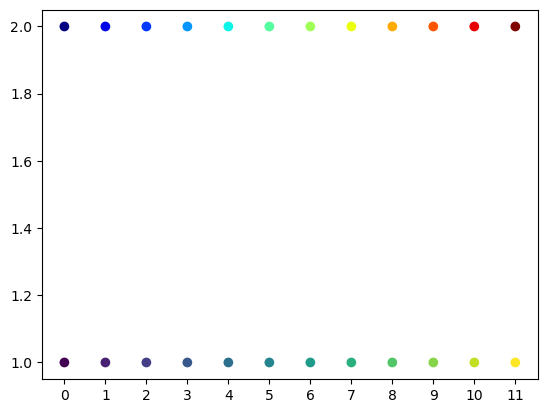

[0.33839342 1.         0.62934851 1.        ]


In [292]:
jet = cm.get_cmap('jet')
jet_12_colors = jet(np.linspace(0, 1, 12))
print('jet.colors', jet_12_colors.shape)

viridis = cm.get_cmap('viridis', 12)
print('viridis.colors', viridis.colors.shape)

plt.scatter(range(12), np.repeat(2, 12), color=jet_12_colors)
plt.scatter(range(12), np.repeat(1, 12), color=viridis.colors)
plt.xticks(range(12))
plt.show()
print(jet_12_colors[5])

In [293]:
V = np.array([
    [0., 0, 0],
    [1, 0, 0],
    [1, 1, 1],
    [2, 1, 0]
])

F = np.array([
    [0, 1, 2],
    [1, 3, 2]
])

color = np.array([
    [1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0]
])

color1 = np.array([
    0.33839342, 1.0, 0.62934851
])

mp.plot(V, F, c=color1)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0, 0.5,…

In [249]:
test = np.array([
    [1,1],
    [2,2]
])

test[0]

array([1, 1])

In [188]:
q.save(filename="frequency_colorful_threshold=5")

Plot saved to file frequency_colorful_threshold=5.html.


In [200]:
"""#Example# get: faces; from: face index"""
F = np.asarray([0,1,2])
G = np.zeros(shape=(1,4))
G[:,0:3] = F
print(G)
# got: 
# [edge_u_index, edge_v_index, face_index] <- edges
# [a_index, b_index, c_index] @ face_index
# [x, y, z] @ a_index
# want:
# select faces by index
# tally appearance count for ea face

[[0. 1. 2. 0.]]


In [198]:
"""#Example# get: vertices; from: vertex index"""
A = np.asarray([[0, 1, 2]]) # edges, form: (u index, v index)
B = np.asarray([[5,6,0],[7,8,0],[9,10,0]]) # verts, form: (x, y, z)
# want: C = [5,6], D = [7,8] <- selected verts by indices; indices from edges
C = np.zeros(shape=(A.shape[0],2))
D = np.zeros(shape=(A.shape[0],2))
for i in range(len(A)):
    C[i] = B[A[i][0]][0:2]
    D[i] = B[A[i][1]][0:2]
print(B[1][0:2])
print(C)
print(D)

[7 8]
[[5. 6.]]
[[7. 8.]]


In [138]:
(V, N, E, CL_vertices, connected_cmp, edges) = RawData(RAVINES)
selected_faces = np.zeros((faces.shape[0],4))
selected_faces[:,0:3] = faces
selected_faces[1]



array([14., 13.,  3.,  0.])

In [135]:
triangle_indices = edges[:,2]
for i in range(len(triangle_indices)):
    if(i != -1):
        selected_faces[3] += 1
print(selected_faces[55498])

[28474. 28472. 24778.     0.]


In [ ]:
# show ravines (very nice)
ravines(RAVINES, verts, faces)

In [ ]:
# show entire mesh (no nothing)
p = mp.plot(verts, faces, return_plot=True)

In [52]:
# Save
p.save("FeatureLines_" + MESHNAME + "_neighbor=" + str(NEIGHBOR))

Plot saved to file FeatureLines_tbk_crop_230328_depth=12_correctNormals_crop_2_neighbor=6.html.


In [103]:
# Reference: 
# http://www.open3d.org/docs/0.11.1/tutorial/visualization/visualization.html
(V, N, E, vertices, connected_cmp, edges) = RawData(RAVINES)
points = vertices[:,:3]
lines = edges[:,:2]
colors = [[1, 0, 0] for i in range(E)]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_line_set(RAVINES + PLY, line_set, print_progress=True)
#test

Writing PLY: [========================================] 100%


True

In [ ]:
# all feature lines
show(RIDGES, RAVINES, verts, faces)
# just show ridges (not very useful)
ridges(RIDGES, verts, faces)